# Анализ результатов A/B-тестирования интернет-магазина BitMotion Kit.

Интернет-магазин BitMotion Kit занимается продажей геймифицированных товаров для тех, кто ведёт здоровый образ жизни. В будущем компания хочет расширить ассортимент товаров. Однако, существует проблема - интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

## Цели и задачи проекта



Цель: 
- Дать обоснованную рекомендацию о внедрении новой версии сайта интернет-магазина BitMotion Kit на основе статистической оценки её влияния на ключевой бизнес-показатель — конверсию в покупку.

Задачи:
- Оценить корректность проведения теста
- Сравнить конверсию в покупку между контрольной (A) и тестовой (B) группами. Проверить статистическую значимость обнаруженных различий

## Содержание

1. Загрузка и предобработка данных

2. Проверка корректности проведения теста

3. Подготовка данных и анализа конверсии

4. Статистический анализ результатов

5. Выводы и рекомендации

----

## 1. Загрузка данных, оценка их целостности


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportions_ztest

In [2]:
participants = pd.read_csv()
events = pd.read_csv(,
                     parse_dates=['event_dt'], low_memory=False)

In [3]:
participants.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


In [4]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


Датасет participants содержит информацию об участниках тестов. Он состоит из 14525 строк и 4 столбцов, типы данных корректны, пропуски отсутствуют.

In [5]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


In [6]:
events.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


Датасет events содержит информацию об действиях пользователей в приложении за 2020 год. Он состоит из 787286 строк и 4 столбцов, типы данных корректны, пропуски присутствуют только в столбце details, в котором содержится дополнительная информация о событии - стоимость привлечения клиента или покупки (для event_name registration или purchase, соответственно), или регионы, в которых проводились промо-кампании.

In [7]:
events.event_name.unique()

array(['End of Black Friday Ads Campaign', 'registration', 'product_page',
       'login', 'product_cart', 'purchase',
       'Start of Christmas&New Year Promo',
       'Start of CIS New Year Gift Lottery'], dtype=object)

In [8]:
events[events['details'].isna()]['event_name'].unique()

array(['product_page', 'login', 'product_cart'], dtype=object)

Пропуски в датасете events присутствуют в столбце details и соответствуют значениям event_name: product_page, login, product_cart. Таким образом, наличие пропусков не мешает дальнейшему анализу. 

Проверим наличие дубликатов в данных.

In [9]:
events.duplicated().sum()

36318

Удалим явные дубликаты.

In [10]:
events=events.drop_duplicates().reset_index(drop=True)


## 2. Оценка корректности проведения теста:

Выделим пользователей, участвующих в тесте, и проверим:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [11]:
#Выведем уникальные значения - названия тестов
participants.ab_test.unique()

array(['interface_eu_test', 'recommender_system_test'], dtype=object)

Таким образом, в таблице представлены 2 теста. Судя по названию, нам необходимо отфильтровать только interface_eu_test. 

In [12]:
interface_participants=participants[participants['ab_test']=='interface_eu_test'].reset_index(drop=True)
interface_participants

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,A,interface_eu_test,Android
2,001E72F50D1C48FA,A,interface_eu_test,Mac
3,002412F1EB3F6E38,B,interface_eu_test,Mac
4,002540BE89C930FB,B,interface_eu_test,Android
...,...,...,...,...
10845,FFE600EEC4BA7685,B,interface_eu_test,Android
10846,FFE7FC140521F5F6,A,interface_eu_test,PC
10847,FFEFC0E55C1CCD4F,A,interface_eu_test,PC
10848,FFF28D02B1EACBE1,B,interface_eu_test,PC


Удалим пользователей, которые оказались участниками обоих тестов.

In [13]:
test_counts=participants.groupby('user_id')['ab_test'].count().reset_index()
#Пользователи, участвовавшие в обоих тестах
ab_users=test_counts[test_counts['ab_test']>1]

In [14]:
interface_participants=interface_participants[~interface_participants['user_id'].isin(ab_users['user_id'])].reset_index(drop=True)

In [15]:
#Рассчитаем количество уникальных пользователей по группам тестирования
interface_participants.groupby('group')['user_id'].nunique()

group
A    4952
B    5011
Name: user_id, dtype: int64

Общее количество пользователей в группах сопоставимо.

In [16]:
group_devices = (interface_participants.groupby(['group', 'device'])['user_id']
                 .count()
                 .reset_index(name='count'))
group_devices['total_per_group'] = group_devices.groupby('group')['count'].transform('sum')
group_devices['percentage'] = (group_devices['count'] / group_devices['total_per_group']) * 100
group_devices = group_devices.drop('total_per_group', axis=1)
pivot_df = group_devices.pivot(index='device', columns='group', values='percentage')
pivot_df


group,A,B
device,,
Android,45.718901,44.262622
Mac,10.399838,10.197565
PC,24.697092,25.982838
iPhone,19.184168,19.556975


<AxesSubplot:title={'center':'Распределение пользователей по устройствам в группах'}, xlabel='Тип устройства', ylabel='Доля пользователей'>

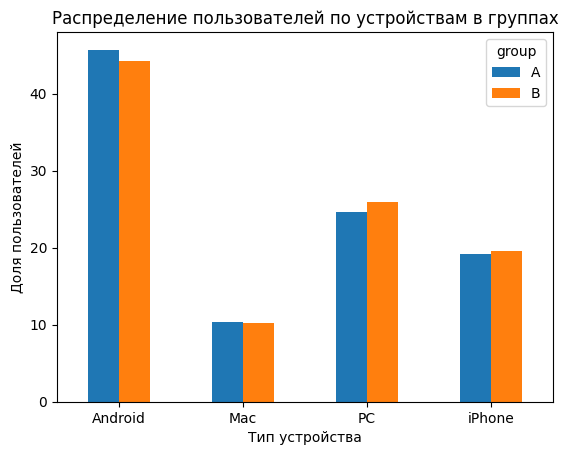

In [17]:
pivot_df.plot(
    kind='bar',
    rot=0,
    xlabel='Тип устройства',
    ylabel='Доля пользователей',
    title='Распределение пользователей по устройствам в группах'
)

Распределение пользователей по типам устройств в группах приблизительно одинаковое. 

In [18]:
(interface_participants.groupby('user_id')['group'].nunique()>1).sum()

0

Отсутствуют пользователи, для которых в столбце group указано более одного уникального значения - следовательно, отсутствуют пользователи, попавшие сразу в обе группы. 

### Промежуточный вывод: 
Данные подходят для проведения А/В-тестирования.

## 3.Подготовка данных и анализ конверсии

Проанализируем данные о пользовательской активности по таблице `ab_test_events`. Оставим только события, связанные с участвующими в изучаемом тесте пользователями

In [19]:
#Объединим датасеты events и interface_participants по идентификаторам пользователя
interface_events=pd.merge(interface_participants,events, on='user_id')
interface_events

,user_id,group,ab_test,device,event_dt,event_name,details
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38
1,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:49,login,NaN
2,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:57,login,NaN
3,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:38:54,login,NaN
4,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:35,login,NaN
...,...,...,...,...,...,...,...
68069,FFEFC0E55C1CCD4F,A,interface_eu_test,PC,2020-12-13 23:52:22,login,NaN
68070,FFEFC0E55C1CCD4F,A,interface_eu_test,PC,2020-12-28 00:29:10,login,NaN
68071,FFF58BC33966EB51,A,interface_eu_test,Android,2020-12-13 17:37:34,registration,-0.45
68072,FFF58BC33966EB51,A,interface_eu_test,Android,2020-12-13 17:56:02,login,NaN


Определим горизонт анализа: рассчитаем время (лайфтайм) совершения события пользователем после регистрации и оставим только те события, которые были выполнены в течение первых семи дней с момента регистрации, а затем рассчитаем для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [20]:
#Определим дату регистрации для каждого пользователя
registration_dates=interface_events[interface_events['event_name']=='registration'][['user_id','event_dt']].rename(columns={'event_dt': 'reg_date'})

#Исключим из датасета все строки, соответствующие регистрации пользователя
filtered_df=pd.merge(interface_events[interface_events['event_name']!='registration'], registration_dates, on='user_id')
#Добавим вспомогательный столбце с лайфтаймом совершения события 
filtered_df['lifetime']=filtered_df['event_dt']-filtered_df['reg_date']
#Отфильтруем события за первые 7 дней после регистрации
events_7_days = filtered_df[filtered_df['lifetime'] < pd.Timedelta(days=7)]

#Пользователи с покупками в 7 дней
purchases_7_days = events_7_days[events_7_days['event_name'] == 'purchase']
buyer_ids = purchases_7_days['user_id'].unique()

#Добавляем флаг покупки
all_users = interface_participants[['user_id', 'group']].copy()
all_users['is_buyer'] = all_users['user_id'].isin(buyer_ids)


conversion = all_users.groupby('group').agg(
    total_users=('user_id', 'nunique'),
    buyers=('is_buyer', 'sum')
)
conversion['conversion_rate'] = conversion['buyers'] / conversion['total_users']
conversion

,total_users,buyers,conversion_rate
group,,,
A,4952,1377,0.278069
B,5011,1480,0.295350


Оценим достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [21]:
# Рассчитаем необходимый размер выборки
alpha = 0.05  
beta = 0.2 
power = 1-beta
p = 0.3 
mde = 0.03
effect_size = proportion_effectsize(p, p + mde)

power_analysis = NormalIndPower()


sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 3761


In [22]:
n_a, n_b = conversion.iloc[0,0], conversion.iloc[1,0] 
m_a, m_b = conversion.iloc[0,1], conversion.iloc[1,1]
p_a, p_b = m_a/n_a, m_b/n_b 
print(f'n_a={n_a}, n_b={n_b}')
print(f'm_a={m_a}, m_b={m_b}')
print(f'p_a={p_a}, p_b={p_b}')

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

n_a=4952, n_b=5011
m_a=1377, m_b=1480
p_a=0.27806946688206785, p_b=0.29535022949511075
Предпосылка о достаточном количестве данных выполняется!


### Промежуточный вывод: 
Величина конверсии в тестовой группе выше, чем в контрольной. Необходимо определить, является ли эта разница статистически значимой.

## 4. Оценка результатов A/B-тестирования:

Проверим изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

Нулевая гипотеза - конверсия в группах А и В одинаковая. Альтернативная гипотеза - конверсия в группе В выше, чем в группе А. 

- H_0: p_a = p_b

- H_1: p_a < p_b

In [23]:
alpha = 0.05

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller'
)
p_value_ztest

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нельзя отклонить нулевую гипотезу. Разница в конверсии не является статистически значимой')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Принимаем альтернативную гипотезу. Конверсия в тестовой группе статистически значимо выше конверсии в контрольной группе')

pvalue=0.028262547212292124 < 0.05
Принимаем альтернативную гипотезу. Конверсия в тестовой группе статистически значимо выше конверсии в контрольной группе


In [24]:
print(f'''Конверсия А, %: {conversion.iloc[0,2]*100:.2f}
Конверсия B, %: {conversion.iloc[1,2]*100:.2f}
Рост конверсии в п.п.:{(conversion.iloc[1,2]-conversion.iloc[0,2])*100:.2f}
p-value={p_value_ztest:.6f}''')

Конверсия А, %: 27.81
Конверсия B, %: 29.54
Рост конверсии в п.п.:1.73
p-value=0.028263


## 5. Выводы 
По результатам рассчетов конверсия в тестовой группе оказалась выше, чем в контрольной группе, на 1.77 процентных пункта (p-value = 0.020307 < alpha ). Однако целевое значение увеличения конверсии (3 п.п.) не было достигнуто. Если эффект экономически значим, рекомендуется внеднить изменения. В том случае, если нужен эффект не менее 3 п.п. требуется увеличить выборку и продолжить тест. 